# Deep Learning &mdash; Assignment 7

Seventh assignment for the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:** Vojko Pjanovic (s1084416); Carmen Gascó Gálvez (s1098566)

**Group:** 10

-----

## Introduction

For this assignment we are doing things a bit different.
* Your task is to reproduce the paper [The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks;      Jonathan Frankle, Michael Carbin](https://arxiv.org/pdf/1803.03635.pdf).
* Try to follow the experimental settings in that paper, unless there is a reason to deviate.
* If the paper is not clear on some details, make a reasonable choice yourself, and motivate that choice.
* You will have 3 weeks to work on this assignment.
* Be aware that this assignment will take more time than previous ones. It is ok if you do not completely finish it.
* We will *not* be providing you with much code. You will have to implement many things yourself.
* You may freely use code from earlier weeks, and from the d2l books. Please add a comment to reference the original source.
* You may *not* use implementations of the paper you find online.

**Tips and hints**
* It is allowed and recommended to use more than just this notebook. Make separate python files for a library of functions, and for training and analyses.
* If you like working with jupyter notebooks: make a separate notebook for trying things out, and keep this one clean.
* Use checkpoint files before and during training.
* In the notebook only display and discuss these results.
* You may add new cells to this notebook as needed.
* While the task is to reproduce parts of a paper, the big picture is more important than the exact details.
* It is allowed to discuss the assignment with other groups, but try not to spoil too much.
* If you get stuck, contact the teachers via discord.

## Required software

If you need to import any additional libraries, add them below.

In [1]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from d2l import torch as d2l
from dl_assignment_7_common import *  # Your functions should go here if you want to use them from scripts
import os
import numpy as np
import torch.nn.utils.prune as prune

device = d2l.try_gpu()

## 7.1 The paper (2 points)

**(a) Read sections 1, 2, and 5 of the paper [The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks; by Jonathan Frankle, Michael Carbin](https://arxiv.org/pdf/1803.03635.pdf)**

We will refer to this as the "LTH paper" from now on, or just "the paper".
To answer some later questions you will also need to look at other sections, and search through the appendices.

**(b) In your own words, briefly explain the key message of the paper.<span style="float:right"> (2 points)</span>**

Note: "briefly" means: a few sentences at most.

The key message of the paper is that a dense feed-forward neural network possibly contains one or multiple sub-networks which are as accurate as the whole network, but with less nodes - the winning lottery ticket. Taking only the sub-network and re-training it with it's initial conditions will lead to similar performance as with the full network, only with less computational needs. The phenomenon is not attributed to the structure of the sub-network, as re-initializing with different parameters does not lead to good performance. Therefore, the specific initialization and structure are required for the sub-network to be efficient.

## 7.2 Models and datasets (9 points)

**(a) What neural network architectures are used in the paper?<span style="float:right"> (1 point)</span>**

Lenet, Conv-2, Conv-4, Conv-6, VGG-19, Resnet-18

To keep things simple, we will start with a simple architecture, corresponding to what the paper calls `Lenet`.

**(b) Define a function that constructs a `Lenet` network using PyTorch.<span style="float:right"> (2 points)</span>**

Copy these definitions to `dl_assignment_7_common.py`.

Hint: see Figure 2.

Note: the LTH paper is not entirely clear about this, but the convolution layers use `padding='same'`.

Lenet has:

0 convolutions

FC Layers: 300,100,10

All weights: 266K

epochs/Batch: 50K/60

Optimizer: Adam 1.2e-3

Pruning rate: fc20%

In [2]:
def create_lenet():
    class LeNet(nn.Module):
        def __init__(self,input,output):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input,300),
                nn.ReLU(),
                nn.Linear(300,100),
                nn.ReLU(),
                nn.Linear(100,output)                
            )
        def forward(self,x):
            x = x.reshape(-1,784) # Flatten the image
            return self.net(x)
    return LeNet

**(c) Define a function that can construct a network given the architecture name.**

To keep the code as generic as possible, we can make function

Move the function below to `dl_assignment_7_common.py`, and don't forget to remove it here.

We will do all our experiments with two datasets: MNIST and FashionMNIST

**(d) Are these datasets also used in the papers?<span style="float:right"> (1 point)</span>**

MNIST is used with Lenet, but FashionMNIST is not used; for the convolutional networks, they used CIFAR10

**(e) Define a function that loads a dataset given the dataset name.<span style="float:right"> (3 points)</span>**

Hint: Standard datasets such as MNIST and CIFAR10 are available in the [torchvision](https://pytorch.org/vision/stable/datasets.html#image-classification) library.

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

**(f) Most of these datasets come with a predefined train/test split. Is this used in the LTH paper? If so, update the dataset loader to return a pair `(trainset, testset)`.<span style="float:right"> (1 point)</span>**

There is a predefined train/test split: 

For MNIST:

"The MNIST dataset consists of 60,000 training examples and 10,000 test examples. We randomly sampled a 5,000-example validation set from the training set and used the remaining 55,000 training examples as our training set for the rest of the paper"

FashionMNIST has the same sizes for the train and test examples, so we will use the same split for this dataset.

**(g) Does the LTH paper use a validation set? If so, update the dataset loader to return `(train_dataset, validation_dataset, test_dataset)`.<span style="float:right"> (1 point)</span>**

Hint: [`random_split`](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split), and/or see assignment 2.

Yes, they use a validation set as seen above; it will consist of 5000 samples out of 60000 for both MNIST and FashionMNIST, and the 55000 remaining will be used for training

## 7.3 Training (12 points)

**(a) What optimization algorithm is used in the paper? What values are used for the hyperparameters?<span style="float:right"> (1.5 points)</span>**

If you are unable to find the values used for some of the hyperparameters, use reasonable default values.

For the Conv-nets, only Adam was used as an optimizer; for VGG-19 and Resnet-18 SGD and Momentum were additionally used.

We set up a table to denote the used hyperparameters

| Model | Optimizer | Learning Rate | Momentum | Batch Size | epoch | Pruning rate 
|-------|-----------|---------------|----------|------------|--------|---------|
| LeNet | Adam      | 0.0012         | -      |  60      | 50K    | 0.2    
| Conv-2 | Adam      | 0.0002        | -      |  60       | 20K   | 0.2    
| Conv-4 | Adam      | 0.0003        | -      |  60       | 25K    |  0.2 
| Conv-6 | Adam      | 0.0003        | -      |  60       | 30K    |  0.2 
| VGG-19 | Adam, SGD, Momentum       | 0.001  | 0.9  |128     | 30K    | 0.2  
| Resnet-18 | Adam, SGD, Momentum    | 0.001   | 0.9  |  128   | 112K | 0.2  

Note: 

1. Many more hyperparameters are tried out in the appendices, but the mentioned values come from the main body of the paper. 
2. The pruning rate pertains to the layers excepting the output layer, which is pruned by half of the mentioned pruning rate.
3. 

**(b) Implement an evaluation function, that evaluates a model on a validation or test set (passed as an argument).<span style="float:right"> (2 points)</span>**

The function should return loss and accuracy.

Hints: the book defines a function for this that you may use (see assignment 3).

For the train/val loss and accuracy we will respectively use the CrossEntropyLoss measure predefined in PyTorch, and the d2l.accuracy function.

Later on, for the test accuracy, we will rely on the d2l.evaluate_accuracy_gpu function to evaluate the model accuracy.

Below functions are from the book, and they will be adapted in the training loop to be more befitting for the task.

```
def evaluate_loss(net, data_iter, loss = nn.CrossEntropyLoss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

def evaluate_accuracy_gpu(net, data_iter, device=d2l.try_gpu): #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
```

**(c) Implement a training loop.<span style="float:right"> (4 points)</span>**

Make sure that the network parameters are saved to a file before and during training.

implemented in `dl_assignment_7_common.py` as function `train`; all the following steps are also integrated.

Because you will be doing many experiments, it would be a shame to have to re-run them when you reload the notebook. A better solution is to save model checkpoints.
See [the tutorial on saving and loading model parameters](https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html) for how to implement this in PyTorch.

**(d) Change the training function so that it saves the model at the start and at the end of training.<span style="float:right"> (1 point)</span>**

Hint: Saving a model requires a filename. Because you will be running many experiments, come up with a descriptive naming convention and/or directory structure. Example: `path = f"checkpoints/model-{arch}-{dataset}-{run}-{phase_of_the_moon}-{iteration}.pth"`.

Hint 2: it is easier to save the whole model, see the bottom of the tutorial.

**(e) Train a simple network on a simple dataset.<span style="float:right"> (1 point)</span>**

You may want to create a new python script (`simple_training.py`), and just load the trained network here instead.

In [4]:
download_datasets = False
get_dataset('mnist','./data', download=download_datasets)
get_dataset('fashionmnist','./data', download=download_datasets)

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fec97fe79a0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fec97fe7b20>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fec97fe7c40>}

model performance {'train loss': 0.015600315507518297, 'train acc': 0.9946, 'val loss': 0.08281274160854518, 'val acc': 0.9816, 'test acc': 0.9802}
early stop model performance {'iteration': 6419, 'train_loss': 0.026775068931560963, 'train_acc': 0.9908181818181818, 'val_loss': 0.08055280934050679, 'val_acc': 0.979, 'test_acc': 0.9779}


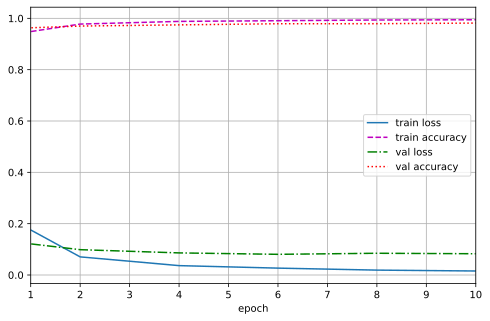

In [188]:
dataset_used = get_dataset('mnist','./data')
net, optimizer = create_network(arch = 'LeNet', input = 784, output = 10)
model_performance, early_stop_values = train(net, optimizer, dataset_used, epochs = 10, val_interval=2, plot = True)

In [189]:
model_performance, early_stop_values

({'train loss': 0.015600315507518297,
  'train acc': 0.9946,
  'val loss': 0.08281274160854518,
  'val acc': 0.9816,
  'test acc': 0.9802},
 {'iteration': 6419,
  'train_loss': 0.026775068931560963,
  'train_acc': 0.9908181818181818,
  'val_loss': 0.08055280934050679,
  'val_acc': 0.979,
  'test_acc': 0.9779})

**(f) Does the training converge? How well does your network perform?<span style="float:right"> (1 point)</span>**

It is safe to say that training has converged; it performs well on both training and validation, and the model generalizes to unseen data as shown by the validation accuracy, and doesn't seem to overfit. 

The test accuracy is also not bad - all-in-all, good performance for the model.

**(g) Re-train the same network, with the same initial weights. Are the results *exactly* the same?<span style="float:right"> (2 points)</span>**

model performance {'train loss': 0.013287278039816936, 'train acc': 0.9955272727272727, 'val loss': 0.0935360619071871, 'val acc': 0.9786, 'test acc': 0.9779}
early stop model performance {'epoch': 2, 'train_loss': 0.06920890383151444, 'train_acc': 0.9784181818181819, 'val_loss': 0.07753174423575401, 'val_acc': 0.9736, 'test_acc': 0.9762}


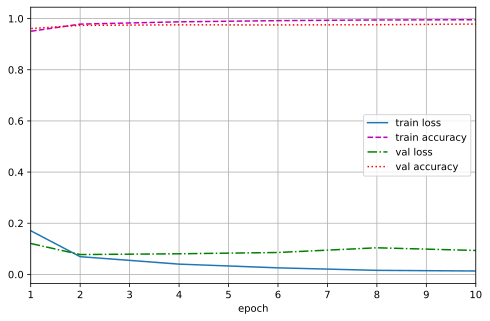

In [17]:
dataset_used = get_dataset('mnist','./data')

net, optimizer = create_network(arch = 'LeNet', input = 784, output = 10)
retrain_net = torch.load(f'./checkpoints/model_LeNet-run_1-before.pth')
net.load_state_dict(retrain_net.state_dict())

retrained_model_performance, retrain_early = train(net, optimizer, dataset_used, epochs = 10, val_interval=2, plot = True)

The results are not *exactly* the same, but they are close to each other; also, the early stopping for the retrained model is at the 2nd epoch instead of the 4th for the initial model.

**(h) The LTH paper uses a variant of 'early-stopping'. How is this done? Implement it in your training loop.<span style="float:right"> (1 point)</span>**

Hint: A simple way to keep track of the best model is to create a model checkpoint in a file `"checkpoints/model-...-best.pth"`.

Hint 2: It is okay to compute the validation scores less often, this can speed up training.

implemented in the above code block. It is a proxy to early-stopping as it does not explicitly stop the training, but merely notes the network at which early-stopping is reached. The test accuracy is also presented at the iteration of minimum validation loss, which has been implemented above as well.

## 7.4 Pruning (11 points)

Next up, you should implement pruning. Starting with the one-shot pruning method.

Hint: 
Pruning is implemented already in PyTorch, in the module [torch.utils.prune](https://pytorch.org/docs/stable/nn.html#module-torch.nn.utils).
The pruning method used in the LTH paper corresponds is called [L1Unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.L1Unstructured.html#torch.nn.utils.prune.L1Unstructured) in PyTorch.

**(a) The PyTorch pruning function accepts an amount to prune. Is that the amount of weights to set to 0 or the amount to keep nonzero? Is the paper using the same?<span style="float:right"> (1 point)</span>**

In the documentation we find that *"**amount** (int or float) – quantity of parameters to prune. If float, should be between 0.0 and 1.0 and represent the fraction of parameters to prune. If int, it represents the absolute number of parameters to prune."*

Therfore, it corresponds to the fraction/amount to be set to 0. 

In the paper it is stated in the pseudo-code for pruning *"prune p% of the parameters in $\theta_j$, creating a mask m"*

Which is esssentially the same, if accounting for the fraction/percentage discrepancy.

**(b) Should all parameters be pruned or only weights? Is the pruning rate the same for all types of layers?<span style="float:right"> (1 point)</span>**

Only the weights are pruned. The pruning rate is not the same for all layers; the connections to the output are pruned at half the rate of the rest of the network.

*"We use a simple layer-wise pruning heuristic: remove a percentage of the weights with the lowest magnitudes within each layer (as in Han et al. (2015)). Connections to outputs are pruned at half of the rate of the rest of the network."*

**(c) Define a function to prune a network as used in the LTH paper. It should take an amount to prune as an argument.<span style="float:right"> (3 points)</span>**

Hint: for a `Sequential` layer, you can access the layers as `net.children()`. For a layer, you can use `isinstance(layer, torch.nn.Linear)` to check if it is a linear layer.

defined in `dl_assignment_7_common.py`

**(d) Check your pruning function on a very simple neural network. Print the network parameters before and after pruning to make sure you understand what is going on.<span style="float:right"> (1 point)</span>**

In [2]:
net, optimizer = create_network(arch = 'LeNet', input = 784, output = 10)
retrain_net = torch.load(f'./checkpoints/model_LeNet-before-LTH_1.pth')
net.load_state_dict(retrain_net.state_dict())
net.state_dict().keys()

print(net.net[0].weight)
mask = L1_prune(net, 0.2)
print('')
print(net.net[0].weight)

mask[0].weight_mask

Parameter containing:
tensor([[-7.0267e-03, -2.9162e-02,  1.8467e-02,  ..., -5.8051e-05,
         -7.4527e-03, -8.9706e-03],
        [-2.6670e-02, -2.7273e-02, -2.5651e-02,  ...,  2.3359e-02,
          2.5158e-02,  1.4038e-02],
        [ 2.1423e-02, -3.4883e-02, -2.3201e-02,  ...,  2.7664e-02,
         -1.4171e-02,  1.3049e-02],
        ...,
        [ 3.1263e-02,  1.5436e-02, -2.4171e-02,  ..., -3.8572e-04,
         -5.9465e-03,  2.2793e-02],
        [-1.8434e-02,  2.6492e-02, -1.0312e-02,  ..., -1.7978e-02,
         -3.0895e-02, -2.8790e-02],
        [ 3.1027e-02, -1.2256e-02, -3.0608e-02,  ..., -1.6220e-02,
          3.5066e-02,  3.5254e-02]], requires_grad=True)

tensor([[-0.0000, -0.0292,  0.0185,  ..., -0.0000, -0.0075, -0.0090],
        [-0.0267, -0.0273, -0.0257,  ...,  0.0234,  0.0252,  0.0140],
        [ 0.0214, -0.0349, -0.0232,  ...,  0.0277, -0.0142,  0.0130],
        ...,
        [ 0.0313,  0.0154, -0.0242,  ..., -0.0000, -0.0000,  0.0228],
        [-0.0184,  0.0265, -0.01

tensor([[0., 1., 1.,  ..., 0., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

As an example we have printed the weights of the first layer before and after pruning; we see that the values with lowest L1 norm are indeed set to 0.

**(e) Define a function that applies the pruning mask from a pruned network to another network of the same architecture.**

This function should only do pruning (so some weights become 0), other weights should remain the same.

Hint: the pruning functions already generate and store pruning masks. You should be able to extract these from a pruned network.

Hint 2: `custom_from_mask`

defined in `dl_assignment_7_common.py`

**(f) Check your mask copy function on a very simple neural network. Check that only the pruning mask is copied.<span style="float:right"> (1 point)</span>**

In [3]:
net, optimizer = create_network(arch = 'LeNet', input = 784, output = 10)
retrain_net = torch.load(f'./checkpoints/model_LeNet-before-LTH_1.pth')
net.load_state_dict(retrain_net.state_dict())

print(net.net[0].weight)
new_net = prune_using_mask(net, mask)
print('')
print(new_net.net[0].weight)

mask[0].weight_mask

Parameter containing:
tensor([[-7.0267e-03, -2.9162e-02,  1.8467e-02,  ..., -5.8051e-05,
         -7.4527e-03, -8.9706e-03],
        [-2.6670e-02, -2.7273e-02, -2.5651e-02,  ...,  2.3359e-02,
          2.5158e-02,  1.4038e-02],
        [ 2.1423e-02, -3.4883e-02, -2.3201e-02,  ...,  2.7664e-02,
         -1.4171e-02,  1.3049e-02],
        ...,
        [ 3.1263e-02,  1.5436e-02, -2.4171e-02,  ..., -3.8572e-04,
         -5.9465e-03,  2.2793e-02],
        [-1.8434e-02,  2.6492e-02, -1.0312e-02,  ..., -1.7978e-02,
         -3.0895e-02, -2.8790e-02],
        [ 3.1027e-02, -1.2256e-02, -3.0608e-02,  ..., -1.6220e-02,
          3.5066e-02,  3.5254e-02]], requires_grad=True)

tensor([[-0.0000, -0.0292,  0.0185,  ..., -0.0000, -0.0075, -0.0090],
        [-0.0267, -0.0273, -0.0257,  ...,  0.0234,  0.0252,  0.0140],
        [ 0.0214, -0.0349, -0.0232,  ...,  0.0277, -0.0142,  0.0130],
        ...,
        [ 0.0313,  0.0154, -0.0242,  ..., -0.0000, -0.0000,  0.0228],
        [-0.0184,  0.0265, -0.01

tensor([[0., 1., 1.,  ..., 0., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

**(g) Define a function that randomly prunes a network.<span style="float:right"> (1 point)</span>**

defined in `dl_assignment_7_common.py`

**(h) Check the above function.<span style="float:right"> (1 point)</span>**

In [4]:
net, optimizer = create_network(arch = 'LeNet', input = 784, output = 10)

retrain_net = torch.load(f'./checkpoints/model_LeNet-before-LTH_1.pth')
net.load_state_dict(retrain_net.state_dict())
net.state_dict().keys()

print(net.net[0].weight)
mask = random_prune(net, 0.2)
print('')
print(net.net[0].weight)

mask[0].weight_mask

Parameter containing:
tensor([[-7.0267e-03, -2.9162e-02,  1.8467e-02,  ..., -5.8051e-05,
         -7.4527e-03, -8.9706e-03],
        [-2.6670e-02, -2.7273e-02, -2.5651e-02,  ...,  2.3359e-02,
          2.5158e-02,  1.4038e-02],
        [ 2.1423e-02, -3.4883e-02, -2.3201e-02,  ...,  2.7664e-02,
         -1.4171e-02,  1.3049e-02],
        ...,
        [ 3.1263e-02,  1.5436e-02, -2.4171e-02,  ..., -3.8572e-04,
         -5.9465e-03,  2.2793e-02],
        [-1.8434e-02,  2.6492e-02, -1.0312e-02,  ..., -1.7978e-02,
         -3.0895e-02, -2.8790e-02],
        [ 3.1027e-02, -1.2256e-02, -3.0608e-02,  ..., -1.6220e-02,
          3.5066e-02,  3.5254e-02]], requires_grad=True)

tensor([[-7.0267e-03, -2.9162e-02,  1.8467e-02,  ..., -5.8051e-05,
         -7.4527e-03, -8.9706e-03],
        [-0.0000e+00, -2.7273e-02, -2.5651e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.1423e-02, -3.4883e-02, -2.3201e-02,  ...,  2.7664e-02,
         -0.0000e+00,  1.3049e-02],
        ...,
   

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 0., 1.],
        ...,
        [1., 1., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 0.,  ..., 0., 1., 0.]])

**(i) Define a function that performs the experiment described in Section 1 of the LTH paper on a given dataset and with a given architecture.<span style="float:right"> (2 points)</span>**

Save all needed results to a file, such as test loss and accuracy. This will make your job easier later on.

defined in `dl_assignment_7_common.py` as `winning_tickets` function

1. determine early stop iterations as a function of remaining percentage of weights
1. do this for a L1 pruned and random network
1. return test accuracy for all of these as well

## 7.5 Confirming the Lottery Ticket Hypothesis (10 points)

**(a) Perform the experiments needed to reproduce the red lines in Figure 1 from the LTH paper.<span style="float:right"> (6 points)</span>**

* It is ok to ignore the error bars for now, and focus on doing one series of experiments.
* You may also reduce the number of points in the plot to keep the computation time managable.
* You do not have to match the visual style of the figure.

Hint: create a python script (`experiment1-{dataset}.py`) that does all the training as needed.
Then load the checkpoint files and do your analysis here.
You may also want to define more helper functions.

Hint 2: look at previous assignments for how to plot. If you do want to include error bars, see also [documentation for `plt.errorbar`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html).

TODO: Training implemented in `TODO.py`

In [ ]:
# TODO: your code here

**(b) Do your results match the paper? Discuss similarities and differences.<span style="float:right"> (2 points)</span>**

TODO: your answer here.

**(c) What can you conclude from this experiment?<span style="float:right"> (2 points)</span>**

TODO: your answer here.

## 7.6 Experiments from Section 2 (12 points)

**(a) What is the difference between the experiment in Figure 1 and Figure 3 of the paper.<span style="float:right"> (1 point)</span>**

Hint: are there differences in the method, the architecture, or the dataset?

TODO: your answer here.

**(b) Implement the iterative pruning method from the paper.<span style="float:right"> (3 points)</span>**

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

**(c) Perform the experiments needed to reproduce Figure 4a from the paper.<span style="float:right"> (4 points)</span>**

Hint: see previous section

TODO: Training implemented in `TODO.py`

In [ ]:
# TODO: your code here

**(d) Do your results match the paper? Discuss similarities and differences.<span style="float:right"> (2 points)</span>**

TODO: your answer here.

**(e) What can you conclude from this experiment?<span style="float:right"> (2 points)</span>**

TODO: your answer here.

## 7.7 Experiments from Section 4 (7 points)

Section 3 and 4 deal with convolutional neural networks. We are going to skip the networks in section 3, and move on to Figure 8.

**(a) Section 4 of the paper describes a slightly different pruning method. Implement that method.<span style="float:right"> (2 points)</span>**

Hint: look at [`torch.nn.utils.prune.global_unstructured`](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.global_unstructured.html) and at the examples on that page.

If you get stuck on this step, you can continue with the same pruning methods as before.

TODO: Function implemented as: `TODO` in `dl_assignment_7_common.py`

**(b) Implement a function that constructs the network architecture used in Figure 8.<span style="float:right"> (1 point)</span>**

Extend the `create_network` function defined earlier.

Hint: VGG16 and Resnet18 are [predefined in torchvision](https://pytorch.org/vision/0.12/models.html).

**(c) Perform the experiments needed to reproduce Figure 8 from the LTH paper.<span style="float:right"> (2 points)</span>**

* Again: you do not need to include error bars.

TODO: Training implemented in `TODO.py`

In [ ]:
# TODO: your code here

**(d) Do your results match the paper? Discuss similarities and differences.<span style="float:right"> (2 points)</span>**

TODO: your answer here.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 63 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 024c4f2 / 2023-10-16</span>